# MiniRocket for Multivariate Time Series Classification

To set the GPU in Google Colab:  <font color = "red"> `Modifier > Paramètres du Notebook > GPU` </font>

In [ ]:
from google.colab import drive
import os

# drive conexion:
drive.mount('/content/drive') 

# Path of the folder containing the project: 
PATH = '/content/drive/My Drive/' + "SII_comportement_vol_ST"
# Path of the folder containing the codes: 
CODE_PATH = PATH + "/code/utilities"
# Path of the folder containing the models:
SAVE_PATH = PATH + "/code/miniRocket_models"

os.chdir(CODE_PATH)

Mounted at /content/drive


In [ ]:
# Install necessary packages
!pip install tsai
!pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 272 kB 5.1 MB/s 
     |████████████████████████████████| 2.5 MB 59.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.9 MB 5.0 MB/s 


In [ ]:
# Call functions previously implemented
from set_path import DATA_PATH,DATA_PATH_TRAIN,DATA_PATH_TEST 
import offline_MiniRocket_v2 as MR 
import save_results as SR
from grid_search_cv import GridSearchCV_MR

# Path to the folder containing the DCAE's weigths
WEIGTHS_PATH = DATA_PATH + '/encoder_weights' 

# Print setup
MR.print_setup()

os              : Linux-5.10.133+-x86_64-with-glibc2.27
python          : 3.8.16
tsai            : 0.3.4
fastai          : 2.7.10
fastcore        : 1.5.27
sktime          : 0.14.1
sklearn         : 1.0.2
torch           : 1.13.0+cu116
device          : 1 gpu (['Tesla T4'])
cpu cores       : 1
threads per cpu : 2
RAM             : 12.68 GB
GPU memory      : [14.75] GB


## I) With feature selection by DCAE

We can tune parameters "by hand", by training the model with several parameters values and keeping the values giving the best accuracy. We can also use GridSearchCV to find the best parameters and then use these parameters to train the model. 

### Load & format datasets

In [ ]:
# Name of the DCAE architecture
DCAE_archi = '/encoder_architecture1_epoch20.h5'

# Path to the folder for saving images 
IMAGE_PATH = PATH + '/results/miniRocket_images/80_20_repartition' + DCAE_archi[:-3]

In [ ]:
# Load Dataset
data_train, data_test = MR.load_datasets(DATA_PATH_TRAIN, DATA_PATH_TEST, 
                                         isDCAE=True, 
                                         weigths_path= WEIGTHS_PATH + DCAE_archi)

Start of data loading...


2/2 [==============================] - 1s 740ms/step
...done!


In [ ]:
# Name of the classification task 
# --> possible values: 'is_error','scenario_name','error_name'
classification_task = 'is_error'


Configuration:
X      - shape: [300 samples x 103 features x 110 timesteps]  type: ndarray  dtype:float32  isnan: 0
y      - shape: (300,)  type: ndarray  dtype:object  n_classes: 11 (27 samples per class) ['None', 'sim/operation/failures/rel_bird_strike', 'sim/operation/failures/rel_collapse1', 'sim/operation/failures/rel_elv_trim_run', 'sim/operation/failures/rel_engfir0', 'sim/operation/failures/rel_engfir1', 'sim/operation/failures/rel_fc_thr', 'sim/operation/failures/rel_fuel_water', 'sim/operation/failures/rel_gen_avio', 'sim/operation/failures/rel_gen_esys', 'sim/operation/failures/rel_hydpmp']  isnan: False
splits - n_splits: 2 shape: [240, 60]  overlap: False


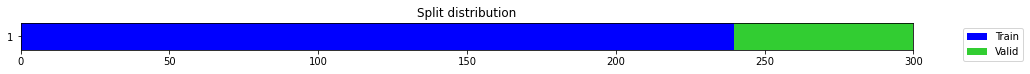

None


In [ ]:
# Create Dataset
X,y,splits = MR.formats_dataset(classification_task, data_train, data_test,isDCAE=True) 

### Use gridSearchCV to find best parameters

In [ ]:
# Using gridSearchCV to find best parameters
# -------------------------------------------
# Parameters are (in this order): dropout, n_epochs, lr 
best_params, best_accuracy = GridSearchCV_MR (X=X[splits[0]], y=y[splits[0]],
                                              classification_task = classification_task,
                                              l_bounds=[0,   7,  1e-5],
                                              u_bounds=[0.5, 20, 1e-2],
                                              n_values = 30,
                                              k=10)

Start of grid search CV...
search 0/30


search 5/30


search 10/30


search 15/30


search 20/30


search 25/30


...done!


In [ ]:
print("best parameters: dropout = {}, n_epoch = {}, lr = {}".format(best_params[0], best_params[1],best_params[2]))
print("best accuracy: ", best_accuracy)

best parameters: dropout = 0.36635368073961466, n_epoch = 15, lr = 0.003736459995072599
best accuracy:  0.8125


### Classification task with best parameters

In [ ]:
# Compute MiniRocket features
X_feat,mrf = MR.offline_MiniRocket_features(
    X,splits,save_path=None,save_name='MRF')


Start of MiniRocket feature computation...
...done!



Start of MiniRocket training...


epoch,train_loss,valid_loss,accuracy,time
0,2.373317,2.262668,0.333333,00:00
1,2.110978,2.372071,0.133333,00:00
2,1.964955,2.155927,0.200000,00:00
3,1.848234,1.769980,0.283333,00:00
4,1.776430,1.239102,0.783333,00:00
5,1.623674,0.959339,0.783333,00:00
6,1.492698,0.923747,0.783333,00:00
7,1.358651,0.935859,0.800000,00:00
8,1.202535,0.947931,0.783333,00:00
9,1.137267,0.997423,0.783333,00:00


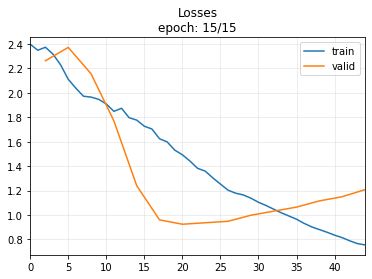

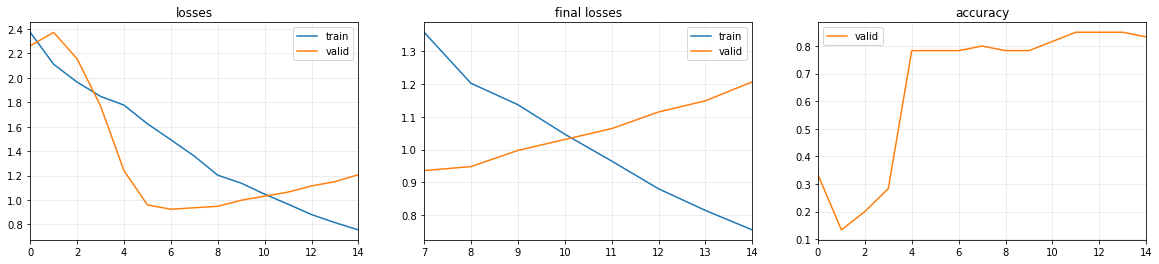

Total time              : 3.599174

...done!


In [ ]:
# Train MiniRocket with best parameters: 
dropout = best_params[0]
n_epoch = best_params[1]
lr = best_params[2]

learn,lr = MR.offline_MiniRocket_training(
    X_feat,y,splits,n_epoch=n_epoch,lr=lr,dropout=dropout, 
    save_path=None,save_name='MRL')


To reduce the amount of guesswork on picking a good starting learning 
rate when training the model, we choose a value that is approximately 
in the middle of the sharpest downward slope on the figure below:



SuggestedLRs(valley=9.120108734350652e-05)


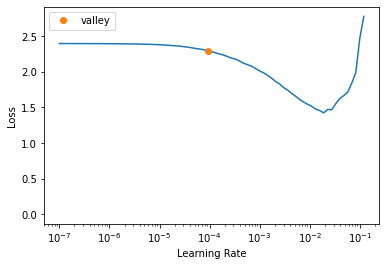


Choose the learning rate (possible value = 5e-4): 1e-3

Start of MiniRocket training...


epoch,train_loss,valid_loss,accuracy,time
0,2.379445,2.367625,0.320000,00:00
1,2.306824,2.324096,0.273333,00:00
2,2.187393,2.297516,0.186667,00:00
3,2.052243,2.294847,0.180000,00:00
4,1.922118,2.167627,0.360000,00:00
5,1.770967,1.919711,0.553333,00:00
6,1.639032,1.832097,0.706667,00:00
7,1.511281,1.717049,0.740000,00:00
8,1.365802,1.607374,0.766667,00:00
9,1.251837,1.451270,0.766667,00:00


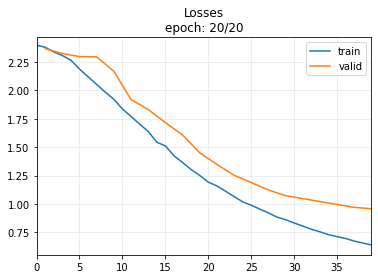

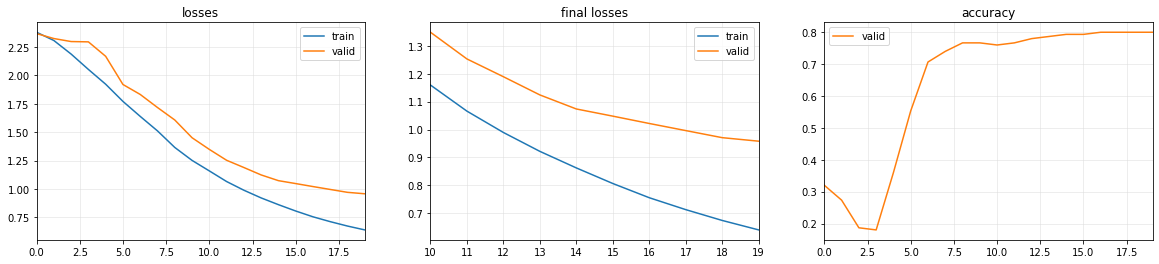

Total time              : 4.577601

...done!


In [ ]:
# Otherwise, Train MiniRocket with your own parameters
"""
n_epoch = 20
dropout = 0.5

# If lr=None, you will choose lr
learn,lr = MR.offline_MiniRocket_training(
    X_feat,y,splits,n_epoch=n_epoch,lr=None,dropout=dropout, 
    save_path=None,save_name='MRL')
"""

Compute prediction...


...done!

Accuracy on the train set: 0.925
F1 score on the train set: 0.8337187070387251


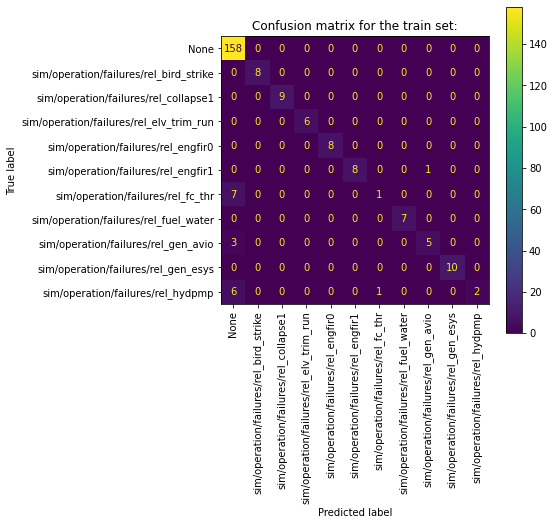


Accuracy on the test set: 0.8333333333333334
F1 score on the test set: 0.5477777777777778


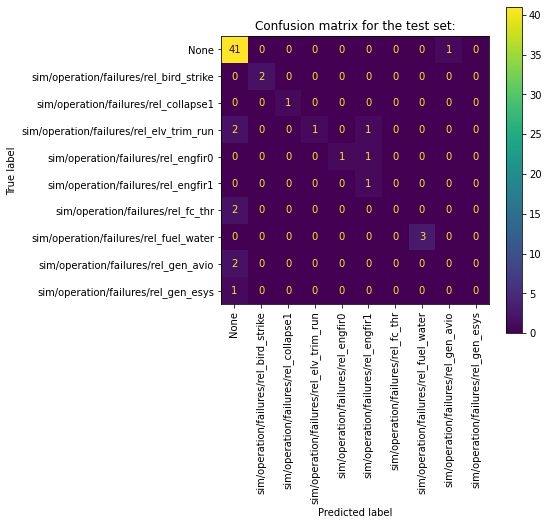

In [ ]:
# Compute predictions
accuracy_score_train, accuracy_score_test, f1_score_train, f1_score_test = MR.offline_MiniRocket_prediction(
    X,y,splits,classification_task,mrf,learn,
    save_path_features=None,save_name_features="MRF",
    save_path_learner=None,save_name_learner="MRL",
    save_path_train_im=IMAGE_PATH,save_path_test_im=IMAGE_PATH)

In [ ]:
# save results
SR.write_results(dataset_used="80/20", DCAE_output= DCAE_archi[1:], 
                 classification_task = classification_task,
                 learning_rate = lr, nb_epochs = n_epoch, dropout = dropout,
                 accuracy_train = accuracy_score_train, 
                 accuracy_test = accuracy_score_test,
                 f1_train = f1_score_train,
                 f1_test = f1_score_test,
                 excel_path = PATH + '/code'
                 )

## II) Without feature selection by DCAE

As before, we can tune parameters "by hand", by training the model with several parameters values and keeping the values giving the best accuracy. We can also use GridSearchCV to find the best parameters and then use these parameters to train the model.

However, using GridSearchCV without feature selection by DCAE is computationally too espansive. Thus, for each classification task, we will use the best parameters found by GridSearchCV on the DCAE output and see if it gives good results on the raw data. Since there is several DCAE architectures, we tale the parameters of the architecture that gave the best accuracy. 

In [ ]:
# Path to the folder for saving images 
IMAGE_PATH = PATH + '/code/miniRocket_images/80_20_repartition' + '/no_encoder'

In [ ]:
# Load Dataset
data_train, data_test = MR.load_datasets(DATA_PATH_TRAIN, DATA_PATH_TEST, isDCAE=False)

Start of data loading...
...done!


### 1) Classification task: detects if there is an error

In [ ]:
classification_task = 'is_error'


Configuration:
X      - shape: [300 samples x 206 features x 3388 timesteps]  type: ndarray  dtype:float32  isnan: 0
y      - shape: (300,)  type: ndarray  dtype:int64  isnan: 0
splits - n_splits: 2 shape: [240, 60]  overlap: False


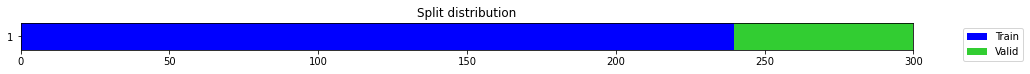

None


In [ ]:
# Create Dataset
X,y,splits = MR.formats_dataset(classification_task, data_train, data_test) 

In [ ]:
# Compute MiniRocket features
X_feat,mrf = MR.offline_MiniRocket_features(
    X,splits,save_path=SAVE_PATH,save_name='MRF')


Start of MiniRocket feature computation...
...done!



Start of MiniRocket training...


epoch,train_loss,valid_loss,accuracy,time
0,0.698727,0.590816,0.700000,00:03
1,0.613979,0.522577,0.750000,00:00
2,0.583809,0.729180,0.716667,00:00
3,0.523336,0.762424,0.766667,00:00
4,0.550951,0.650033,0.800000,00:00
5,0.622592,1.081880,0.750000,00:00
6,0.760990,2.105042,0.733333,00:00
7,0.865151,2.146597,0.750000,00:00
8,0.918225,1.557230,0.800000,00:00
9,0.910652,1.750417,0.800000,00:00


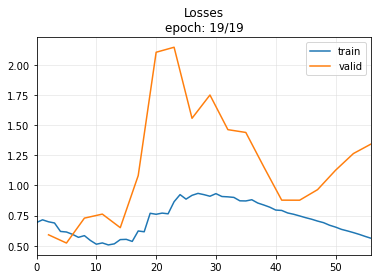

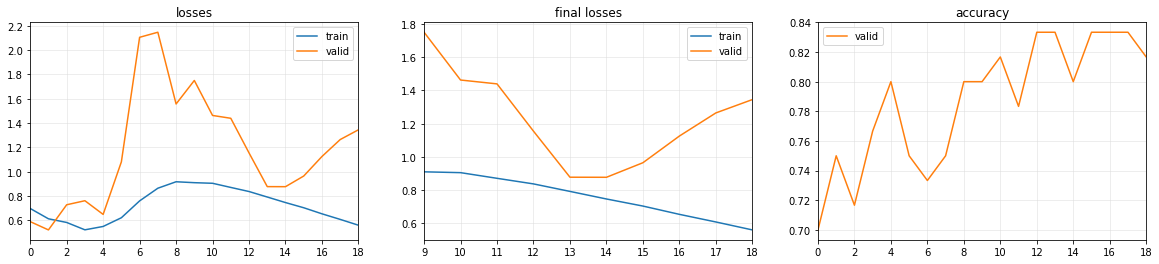

Total time              : 7.322626

...done!


In [ ]:
# Train MiniRocket 
dropout = 0.386287007036846
n_epoch = 19
lr = 0.008453636685931016

learn,lr = MR.offline_MiniRocket_training(
    X_feat,y,splits,n_epoch=n_epoch,lr=lr,dropout=dropout, 
    save_path=None,save_name='MRL')

Compute prediction...


...done!

Accuracy on the train set: 0.975
F1 score on the train set: 0.971875


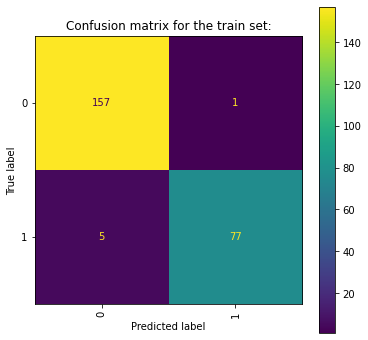


Accuracy on the test set: 0.8166666666666667
F1 score on the test set: 0.7781512605042017


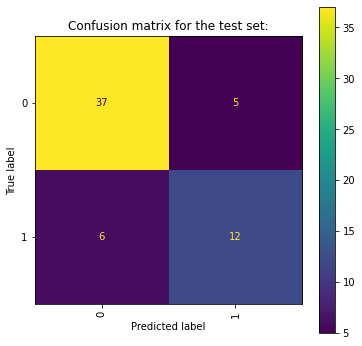

In [ ]:
# Compute predictions
accuracy_score_train, accuracy_score_test, f1_score_train, f1_score_test = MR.offline_MiniRocket_prediction(
    X,y,splits,classification_task,mrf,learn,
    save_path_features=None,save_name_features="MRF",
    save_path_learner=None,save_name_learner="MRL",
    save_path_train_im=IMAGE_PATH,save_path_test_im=IMAGE_PATH)

In [ ]:
# save results
SR.write_results(dataset_used="80/20", DCAE_output="No", 
                 classification_task = classification_task,
                 learning_rate = lr, nb_epochs = n_epoch, dropout = dropout,
                 accuracy_train = accuracy_score_train, 
                 accuracy_test = accuracy_score_test,
                 f1_train = f1_score_train,
                 f1_test = f1_score_test,
                 excel_path = PATH + '/code'
                 )

### 2) Classification task: detects the scenario

In [ ]:
classification_task = 'scenario_name'


Configuration:
X      - shape: [300 samples x 206 features x 3388 timesteps]  type: ndarray  dtype:float32  isnan: 0
y      - shape: (300,)  type: ndarray  dtype:object  n_classes: 5 (60 samples per class) ['ScenarioInstanceListTakeOff', 'ScenarioInstanceListTakeOffAndTurn', 'ScenarioInstanceListTakeOffAndTurnV2', 'ScenarioInstanceListTakeOffAndTurnV3', 'ScenarioInstanceListTakeOffAndTurnV4']  isnan: False
splits - n_splits: 2 shape: [240, 60]  overlap: False


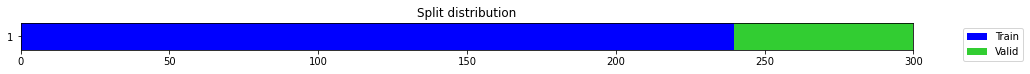

None


In [ ]:
# Create Dataset
X,y,splits = MR.formats_dataset(classification_task, data_train, data_test) 

In [ ]:
# Compute MiniRocket features
# ---> already done in classification task 1)


Start of MiniRocket training...


epoch,train_loss,valid_loss,accuracy,time
0,1.440635,1.691770,0.200000,00:00
1,1.175724,1.755586,0.250000,00:00
2,0.936705,1.620121,0.233333,00:00
3,0.726546,1.256541,0.550000,00:00
4,0.579422,0.878285,0.783333,00:00
5,0.475719,0.655980,0.816667,00:00
6,0.399056,0.565184,0.900000,00:00
7,0.345048,0.529582,0.883333,00:00
8,0.313477,0.533880,0.833333,00:00
9,0.279639,0.472625,0.866667,00:00


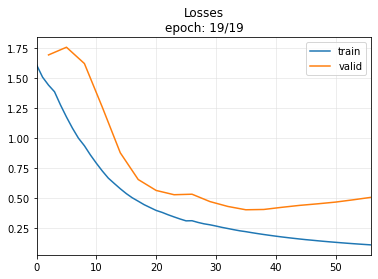

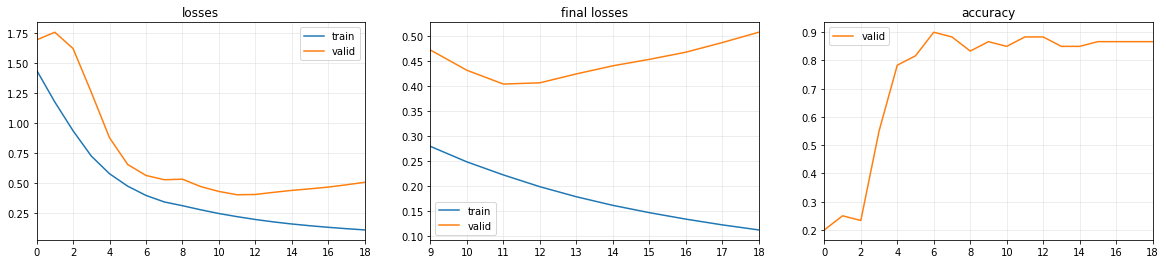

Total time              : 4.318745

...done!


In [ ]:
# Train MiniRocket 
del learn #delete previous learner to not re-train it
dropout = 0.0621969810442918
n_epoch = 19
lr = 0.0021350966073492845		

learn,lr = MR.offline_MiniRocket_training(
    X_feat,y,splits,n_epoch=n_epoch,lr=lr,dropout=dropout, 
    save_path=SAVE_PATH,save_name='MRL')

Compute prediction...


...done!

Accuracy on the train set: 1.0
F1 score on the train set: 1.0


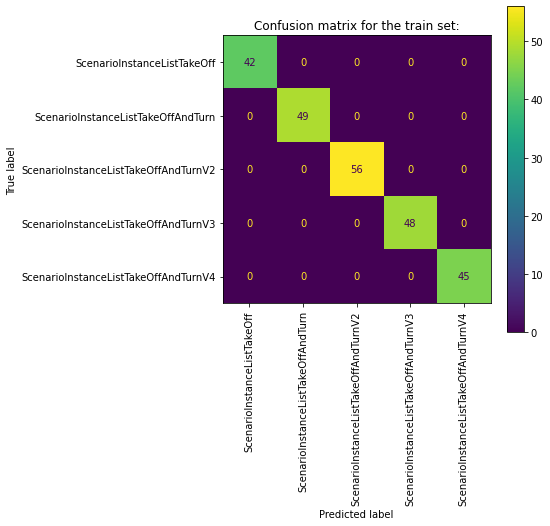


Accuracy on the test set: 0.8666666666666667
F1 score on the test set: 0.8511428571428572


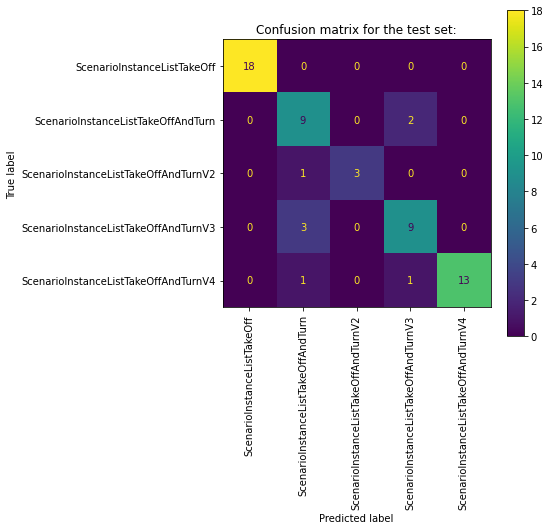

In [ ]:
# Compute predictions
accuracy_score_train, accuracy_score_test, f1_score_train, f1_score_test  = MR.offline_MiniRocket_prediction(
    X,y,splits,classification_task,mrf,learn,
    save_path_features=None,save_name_features="MRF",
    save_path_learner=None,save_name_learner="MRL",
    save_path_train_im=IMAGE_PATH,save_path_test_im=IMAGE_PATH)

In [ ]:
# save results
SR.write_results(dataset_used="80/20", DCAE_output="No", 
                 classification_task = classification_task,
                 learning_rate = lr, nb_epochs = n_epoch, dropout = dropout,
                 accuracy_train = accuracy_score_train, 
                 accuracy_test = accuracy_score_test,
                 f1_train = f1_score_train,
                 f1_test = f1_score_test,
                 excel_path = PATH + '/code'
                 )

### 2) Classification task: detects the type of error

In [ ]:
classification_task = 'error_name'


Configuration:
X      - shape: [300 samples x 206 features x 3388 timesteps]  type: ndarray  dtype:float32  isnan: 0
y      - shape: (300,)  type: ndarray  dtype:object  n_classes: 11 (27 samples per class) ['None', 'sim/operation/failures/rel_bird_strike', 'sim/operation/failures/rel_collapse1', 'sim/operation/failures/rel_elv_trim_run', 'sim/operation/failures/rel_engfir0', 'sim/operation/failures/rel_engfir1', 'sim/operation/failures/rel_fc_thr', 'sim/operation/failures/rel_fuel_water', 'sim/operation/failures/rel_gen_avio', 'sim/operation/failures/rel_gen_esys', 'sim/operation/failures/rel_hydpmp']  isnan: False
splits - n_splits: 2 shape: [240, 60]  overlap: False


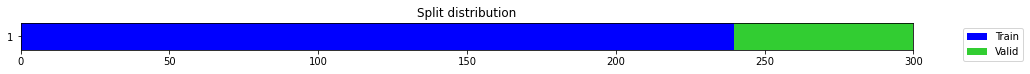

None


In [ ]:
# Create Dataset
X,y,splits = MR.formats_dataset(classification_task, data_train, data_test) 

In [ ]:
# Compute MiniRocket features
# ---> already done in classification task 1)


Start of MiniRocket training...


epoch,train_loss,valid_loss,accuracy,time
0,2.357716,2.157970,0.533333,00:00
1,2.030810,1.969202,0.533333,00:00
2,1.738592,1.172877,0.733333,00:00
3,1.521481,1.047880,0.716667,00:00
4,1.338738,1.223120,0.716667,00:00
5,1.268708,1.562822,0.750000,00:00
6,1.212154,1.711621,0.750000,00:00
7,1.225866,1.623440,0.750000,00:00
8,1.208507,1.629531,0.750000,00:00
9,1.188392,1.660564,0.783333,00:00


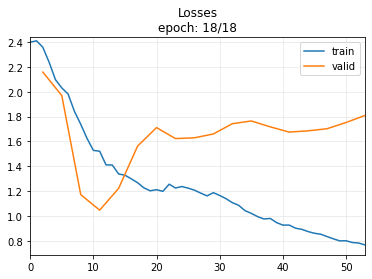

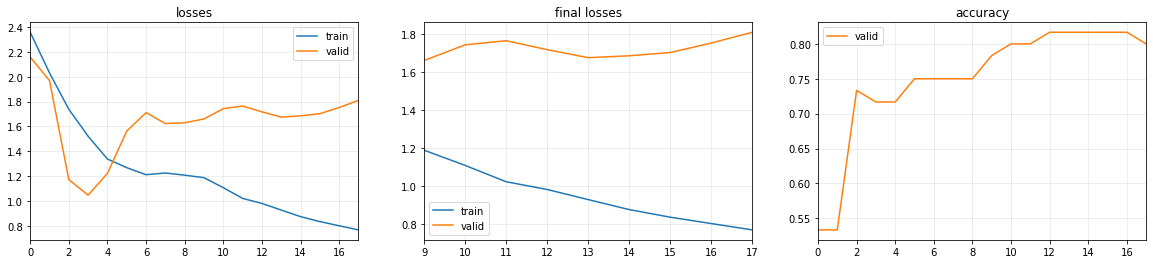

Total time              : 3.939521

...done!


In [ ]:
# Train MiniRocket 
del learn #delete previous learner to not re-train it

dropout = 0.49972478341954335
n_epoch = 18
lr = 0.005199134448954253

learn,lr = MR.offline_MiniRocket_training(
    X_feat,y,splits,n_epoch= n_epoch,lr=lr,dropout=dropout, 
    save_path=SAVE_PATH,save_name='MRL')

Compute prediction...


...done!

Accuracy on the train set: 0.9333333333333333
F1 score on the train set: 0.8792699724517906


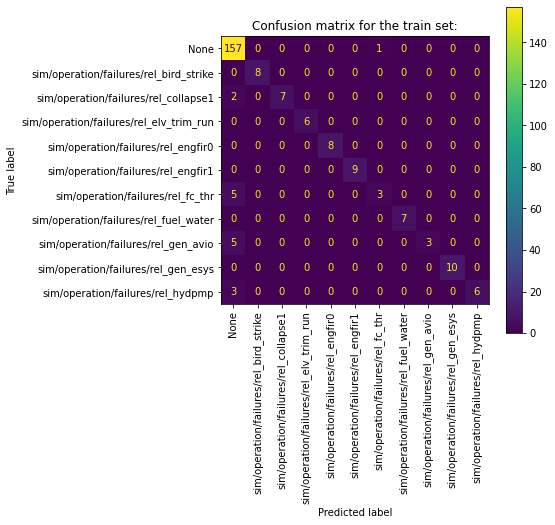


Accuracy on the test set: 0.8
F1 score on the test set: 0.4968675519237317


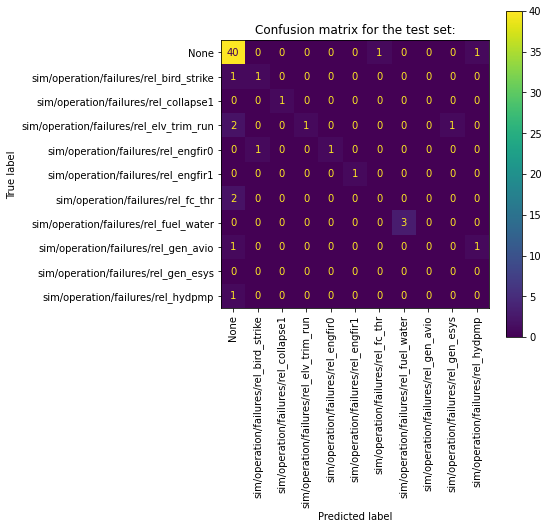

In [ ]:
# Compute predictions
accuracy_score_train, accuracy_score_test, f1_score_train, f1_score_test = MR.offline_MiniRocket_prediction(
    X,y,splits,classification_task,mrf,learn,
    save_path_features=None,save_name_features="MRF",
    save_path_learner=None,save_name_learner="MRL",
    save_path_train_im=IMAGE_PATH,save_path_test_im=IMAGE_PATH)

In [ ]:
# save results
SR.write_results(dataset_used="80/20", DCAE_output="No", 
                 classification_task = classification_task,
                 learning_rate = lr, nb_epochs = n_epoch, dropout = dropout,
                 accuracy_train = accuracy_score_train, 
                 accuracy_test = accuracy_score_test,
                 f1_train = f1_score_train,
                 f1_test = f1_score_test,
                 excel_path = PATH + '/code'
                 )